# Z-Position and dependencies of KR-83m events

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import pandas as pd

In [2]:
#import subprocess
#subprocess.check_call(["latex"])

## Data Import

In [3]:
ctx = straxbra.XebraContext()

In [4]:
run = '00158' # '00201' / '00158'
filenameprefix = 'run_'+run
peaks_data = ctx.get_array(run, 'peaks')

In [5]:
ctx.data_info('peaks')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,float32,Integral across channels in photoelectrons
5,area_per_channel,"('<f4', (8,))",Integral per channel in PE
6,n_hits,int32,Number of hits from which peak was constructed...
7,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
8,width,"('<f4', (11,))",Peak widths in ns: range of central area fraction
9,area_decile_from_midpoint,"('<f4', (11,))",Peak widths in ns: area from midpoint


In [6]:
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5] # 50 % width
timestamp = peaks_data['time']
area_per_channel = peaks_data['area_per_channel']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]
print(waveform.shape)

(3969398, 200)


## Data Processing

In [7]:
## Cut condition first and second Kr-83m S1

def CutCondition(waveform, i):  
    
    FirstPeak_area = sum(waveform[i][:15]) # range in samples (not ns!)
    Risetime_first_peak = np.argmax(waveform[i][:15])*10 # peak time in ns, sampling rate digitizer 10^8 GHz
    SecondPeak_area = sum(waveform[i][15:]) # range in samples (not ns!)
    Risetime_second_peak = np.argmax(waveform[i][15:])*10 # peak time in ns, sampling rate digitizer 10^8 GHz
    
    if  FirstPeak_area > 100 and FirstPeak_area < 600 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
        #print (i , secondS1_area, secondS1_peaktime)
        return(True, Risetime_first_peak, Risetime_second_peak)
    else:
        return(False, 0, 0)
    

In [8]:
def Process(waveform, i):

    CutFlag, Risetime_first_peak, Risetime_second_peak = CutCondition(waveform, i)
    if CutFlag == True:
        
        found = False
        k = 1
        
        time_limit = 65000 # 65000 for E_D = 50 V/cm
        
        #while(found == False and k <= 9):
        while(found == False and timestamp[i+k] < timestamp[i]+time_limit):
            
            #if integral[i+k] > 300 and width[i+k] >200 and width[i+k] < 2000 and timestamp[i+k] < timestamp[i]+time_limit:
            if integral[i+k] > 300 and width[i+k] >200 and width[i+k] < 2000: 
                Kr_S2_area.append(integral[i+k])
                Kr_S2_width.append(width[i+k])
                Kr_S2_risetime.append(risetime[i+k])
                Kr_drifttime.append(timestamp[i+k] - timestamp[i])
                
                found = True
                
            else:
                k = k+1

In [9]:
num = len(waveform)

Kr_S2_area = []
Kr_S2_width = []
Kr_S2_risetime = []
Kr_drifttime = []

print_counter = 0.0
for i in range(0,num):
    
    Process(waveform,i)
    
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
        
print(1.0)

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0


## Evaluation

### Fit distribution counts

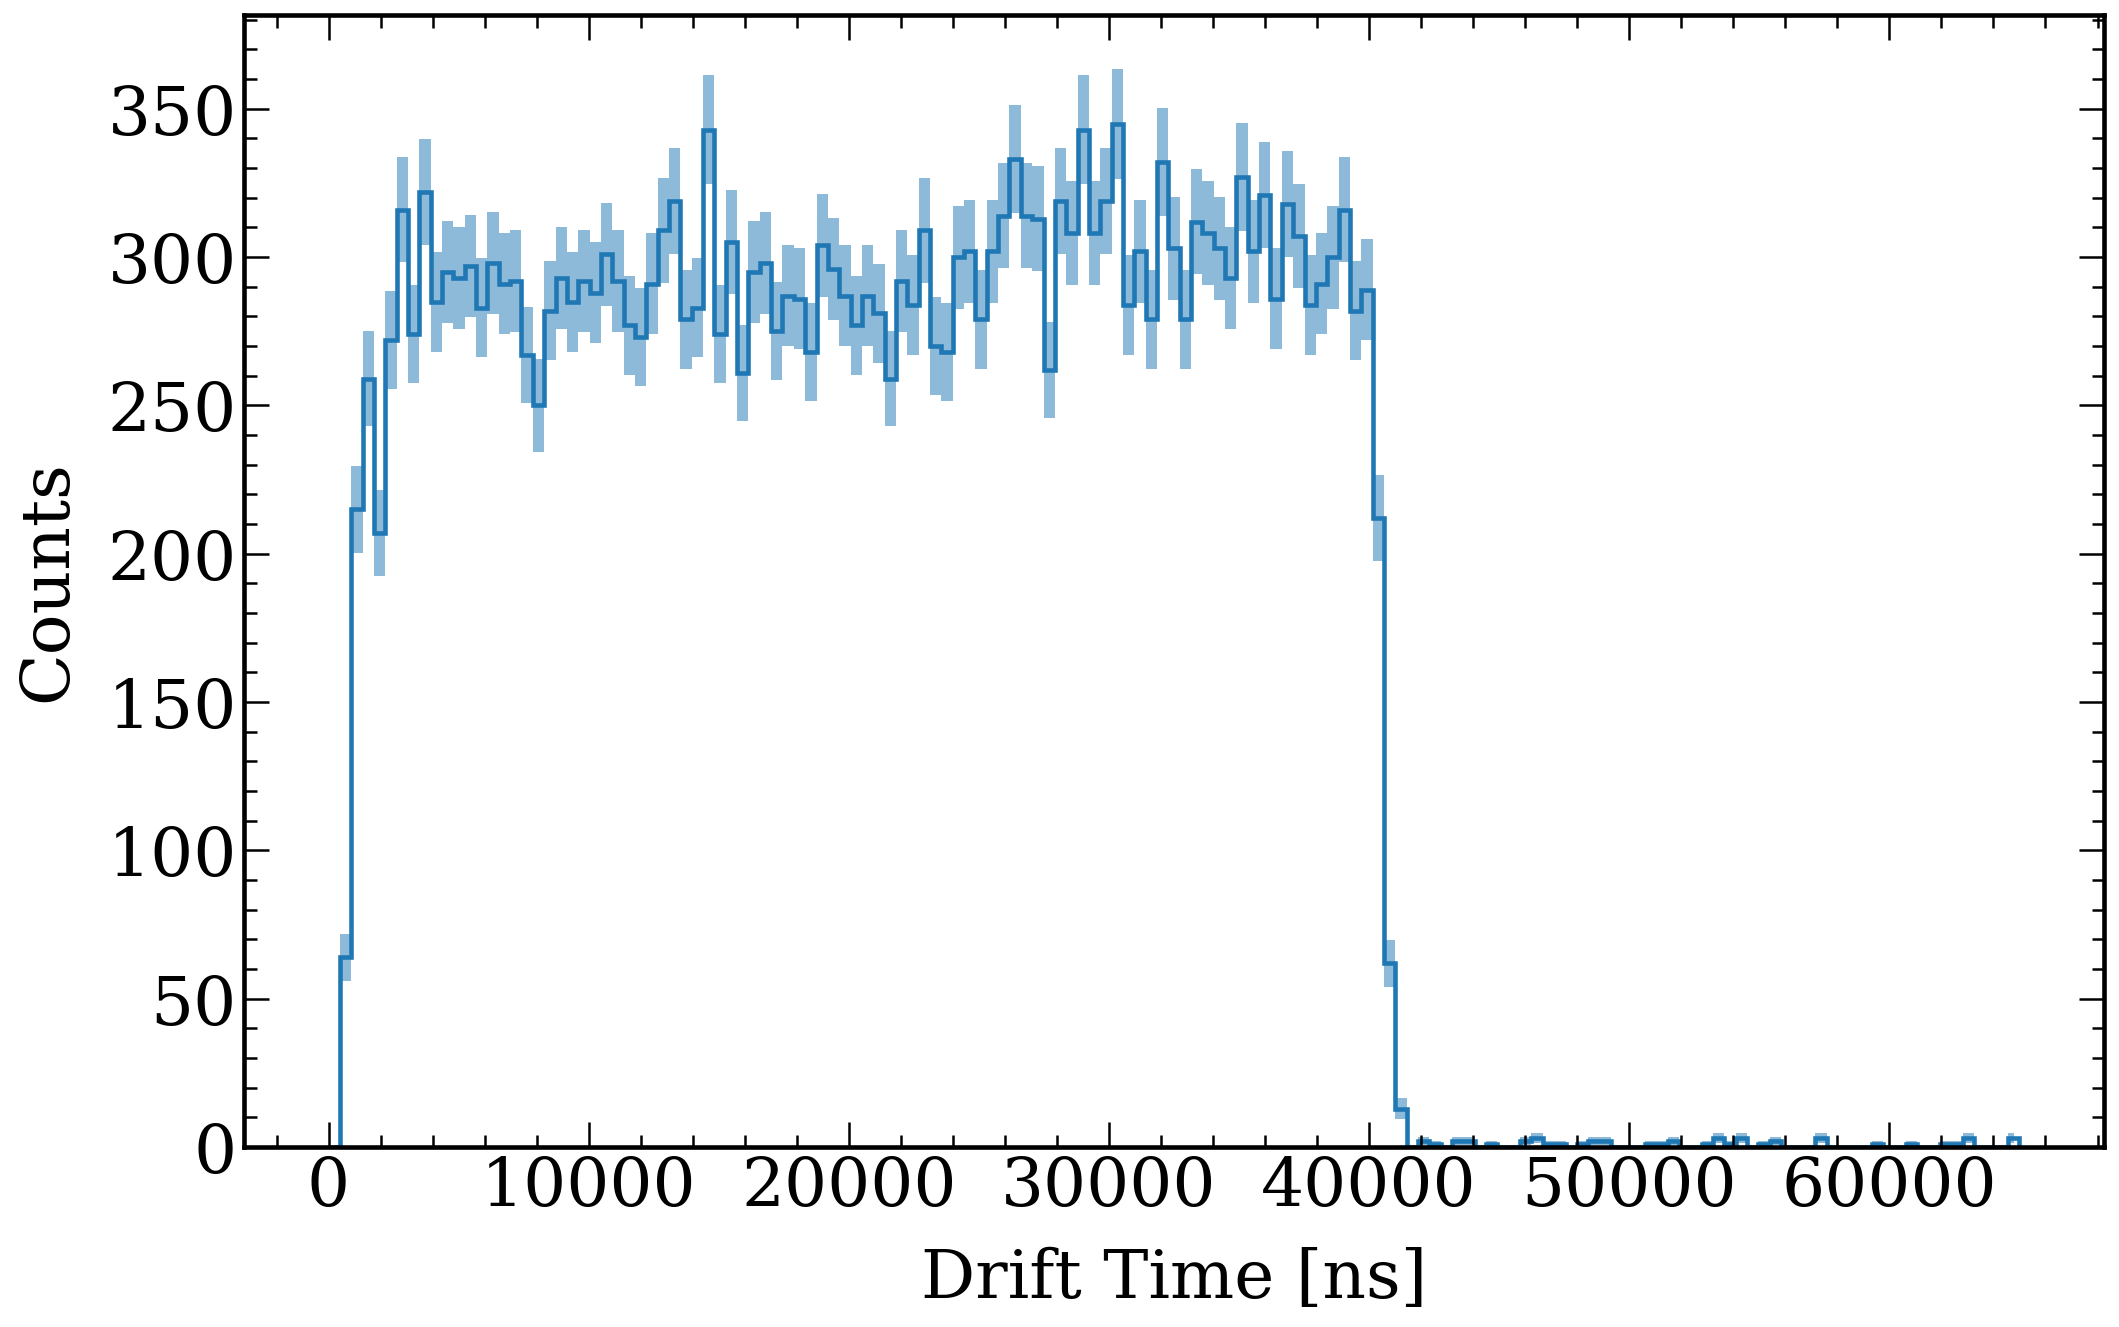

In [10]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
time_limit = 65000 # 65000 for E_D = 50 V/cm

bins = 150
bins_x = np.linspace(0,time_limit,bins)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

counts,_, patches = plt.hist(Kr_drifttime, bins=bins_x, density = False, 
                             histtype='step', linewidth = 2.2, color = 'C0')

plt.fill_between(bins_x_center, counts - np.sqrt(counts), counts + np.sqrt(counts), 
                 facecolor='C0', alpha=0.5, step = 'mid')

plt.xlabel('Drift Time [ns]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

#plt.xlim(0, time_limit)
plt.ylim(bottom = 0)

'''# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)'''

fig.savefig(filenameprefix+"_drifttime.png")
plt.show()

In [11]:
def box(x, x1, x2):
    return 0.5 * (np.sign(x-x1) + 1) * 0.5 * (np.sign(x2-x) + 1)

def lin(x, a, b):
    return a + b * x

def linbox(x, x1, x2, a, b):
    return 0.5 * (np.sign(x-x1) + 1) * 0.5 * (np.sign(x2-x) + 1) * (a + b * x)

def linstep(x, x2, a, b):
    #return np.piecewise(x, [x <= x2, x > x2], [lambda x: (a + b * x), 0])
    return 0.5 * (np.sign(x2-x) + 1) * (a + b * x)

In [12]:
# set counts below threshold to 0

cut_min_counts = max(counts)*0.05
#cut_min_counts = np.sqrt(max(counts))
cut_min_counts_mask = counts > cut_min_counts

counts_cut = counts*cut_min_counts_mask

In [13]:
# extend to negative drift time to improve fit

len_concat = 5
bins_x_center_extended = np.concatenate((-bins_x_center[0:len_concat][::-1], 
                                         bins_x_center), axis=0)

counts_cut_extended = np.concatenate((np.array([0]*len_concat), 
                                      counts_cut), axis=0)

In [14]:
# fit lin for first feeling

time_limit = 65000 # 65000 for E_D = 50 V/cm
not_cut = np.sum(cut_min_counts_mask)*time_limit/bins
bnds = ((max(counts)/4,-max(counts)/not_cut),
        (2*max(counts), max(counts)/not_cut))
print(bnds)

popt, pcov = curve_fit(lin, bins_x_center[10:-60], counts_cut[10:-60], 
                       bounds = bnds)
popt_lin = popt
print(popt)
print([np.sqrt(pcov[i,i]) for i in range(len(popt))])

((86.25, -0.008560794044665013), (690.0, 0.008560794044665013))
[2.80526692e+02 6.83730434e-04]
[4.965125136183033, 0.0002088365971138957]


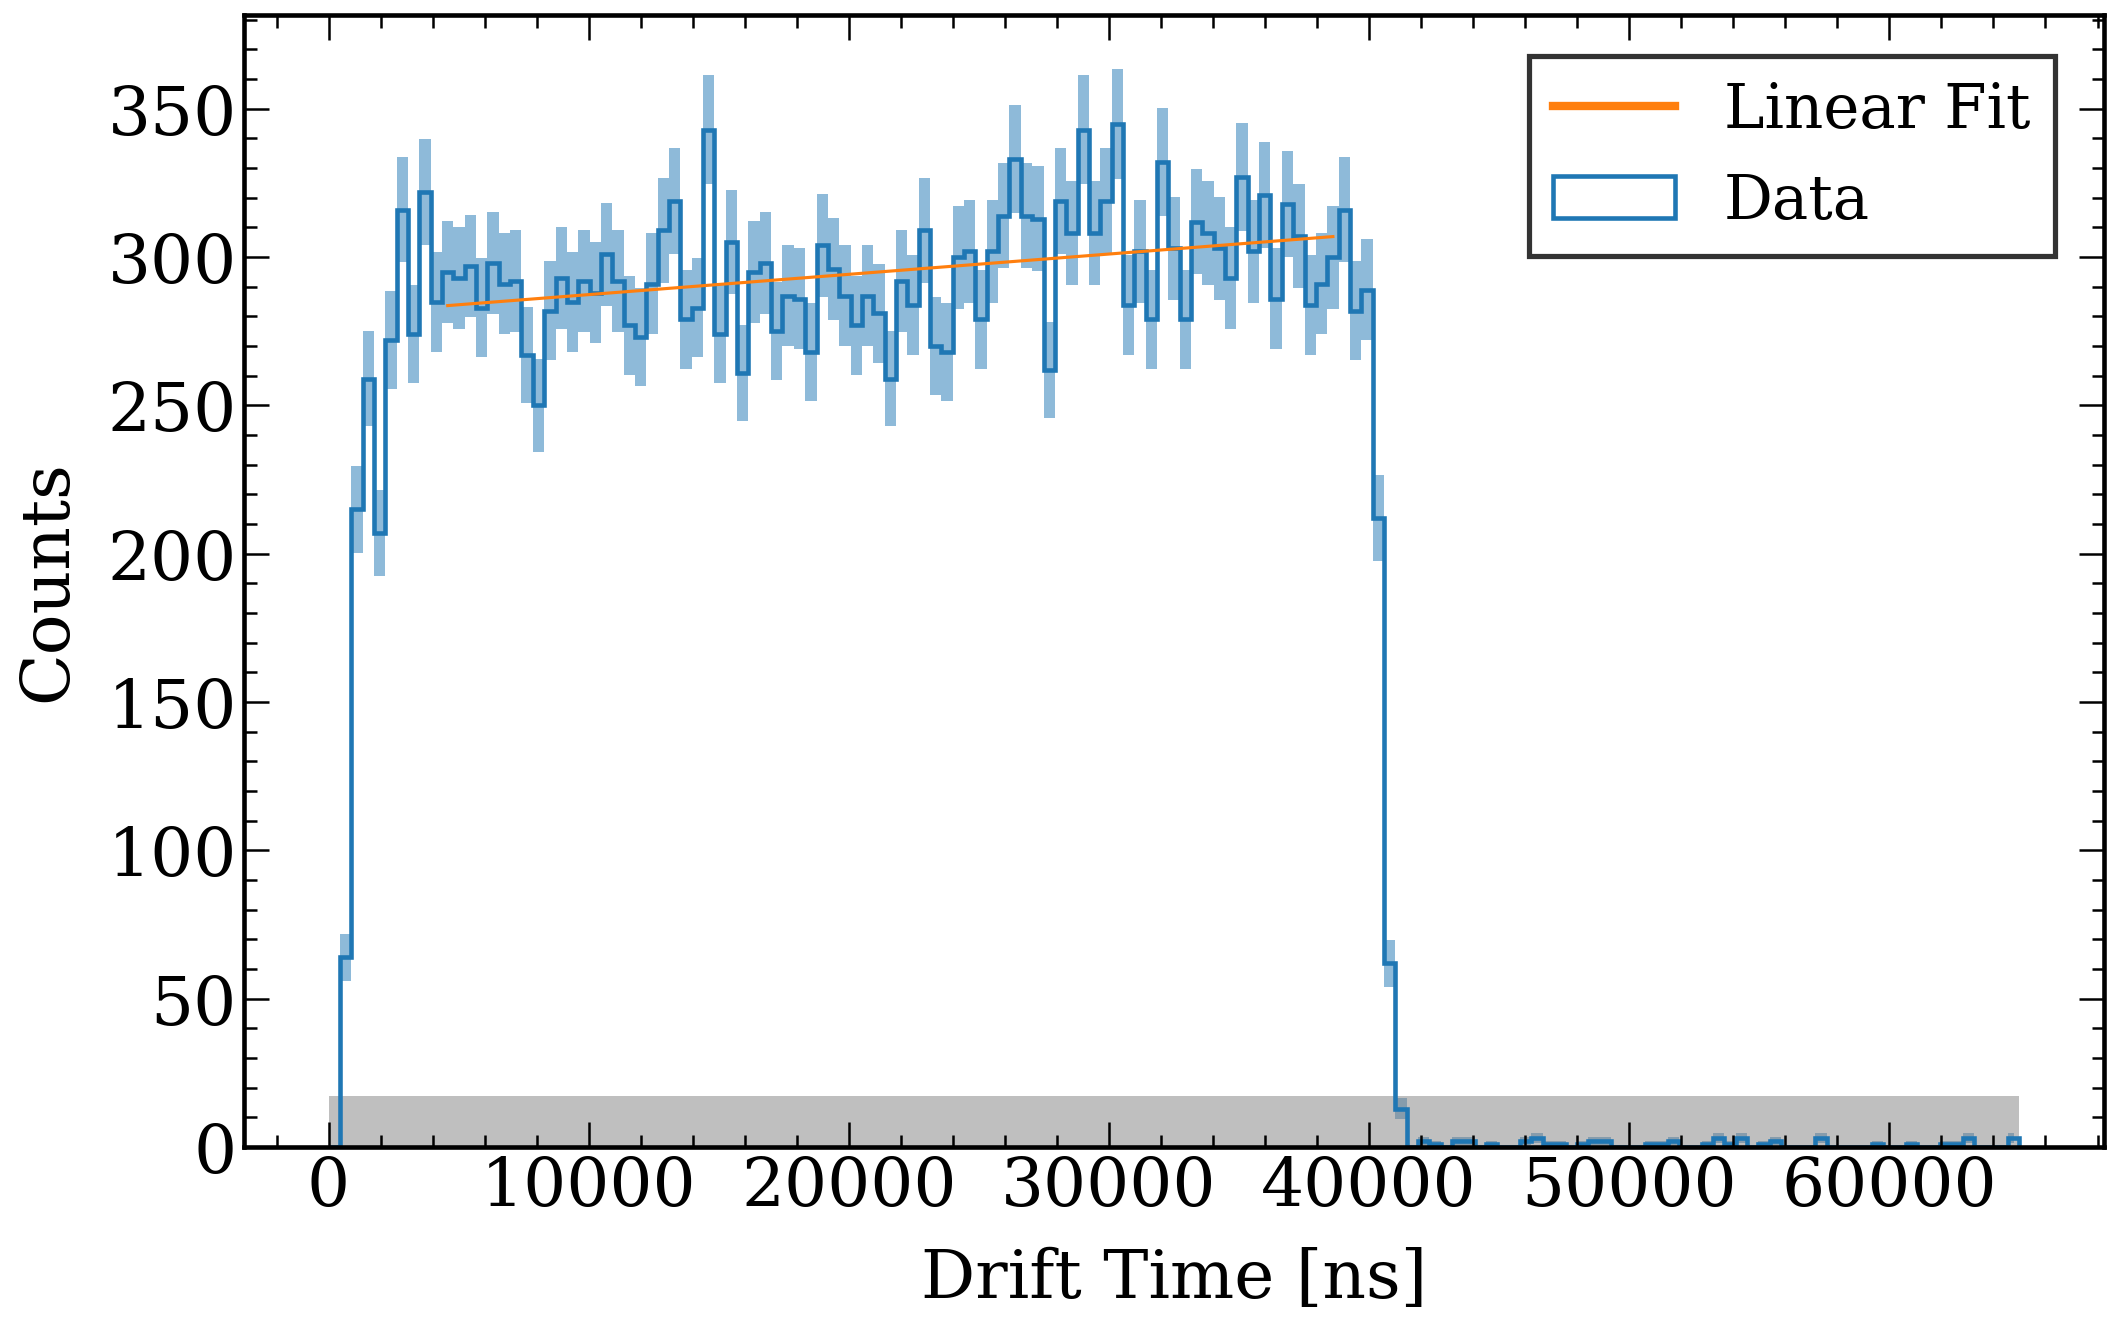

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
time_limit = 65000 # 65000 for E_D = 50 V/cm

bins_x = np.linspace(0,time_limit,150)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

counts,_, patches = plt.hist(Kr_drifttime, bins=bins_x, density = False, 
                            histtype='step', linewidth = 2.2, color = 'C0',
                            label = 'Data')

plt.plot(bins_x_center[10:-60], lin(bins_x_center[10:-60], *popt), label = 'Linear Fit', color = 'C1')
plt.plot

plt.fill_between(bins_x_center, counts - np.sqrt(counts), counts + np.sqrt(counts), 
                 facecolor='C0', alpha=0.5, step = 'mid')

plt.fill_between(bins_x, 0, cut_min_counts, 
                 facecolor='gray', alpha=0.5, step = 'mid'
                 #, label = 'Excluded\nfrom fit'
                )

plt.xlabel('Drift Time [ns]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

#plt.xlim(0, time_limit)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

plt.show()

In [16]:
# fit linstep
# fails so far

time_limit = 65000 # 65000 for E_D = 50 V/cm
not_cut = np.sum(cut_min_counts_mask)*time_limit/bins
bnds = ((not_cut*0.7, max(counts)/4, -max(counts)/not_cut),
        (time_limit, 2*max(counts), max(counts)/not_cut))
guess = np.array([40500, popt_lin[0], popt_lin[1]])
print(bnds)

drop_first_n = math.ceil(np.sum(cut_min_counts_mask)*0.05) # drop first 5% of entries

popt, pcov = curve_fit(linstep, bins_x_center[drop_first_n:], 
                       counts_cut[drop_first_n:], bounds = bnds, p0 = guess)
print(popt)
print([np.sqrt(pcov[i,i]) for i in range(len(popt))])

((28210.0, 86.25, -0.008560794044665013), (65000, 690.0, 0.008560794044665013))
[4.05000000e+04 2.80526661e+02 5.84806976e-04]
[0.0, 4.032225009191593, 0.0001674691821997843]


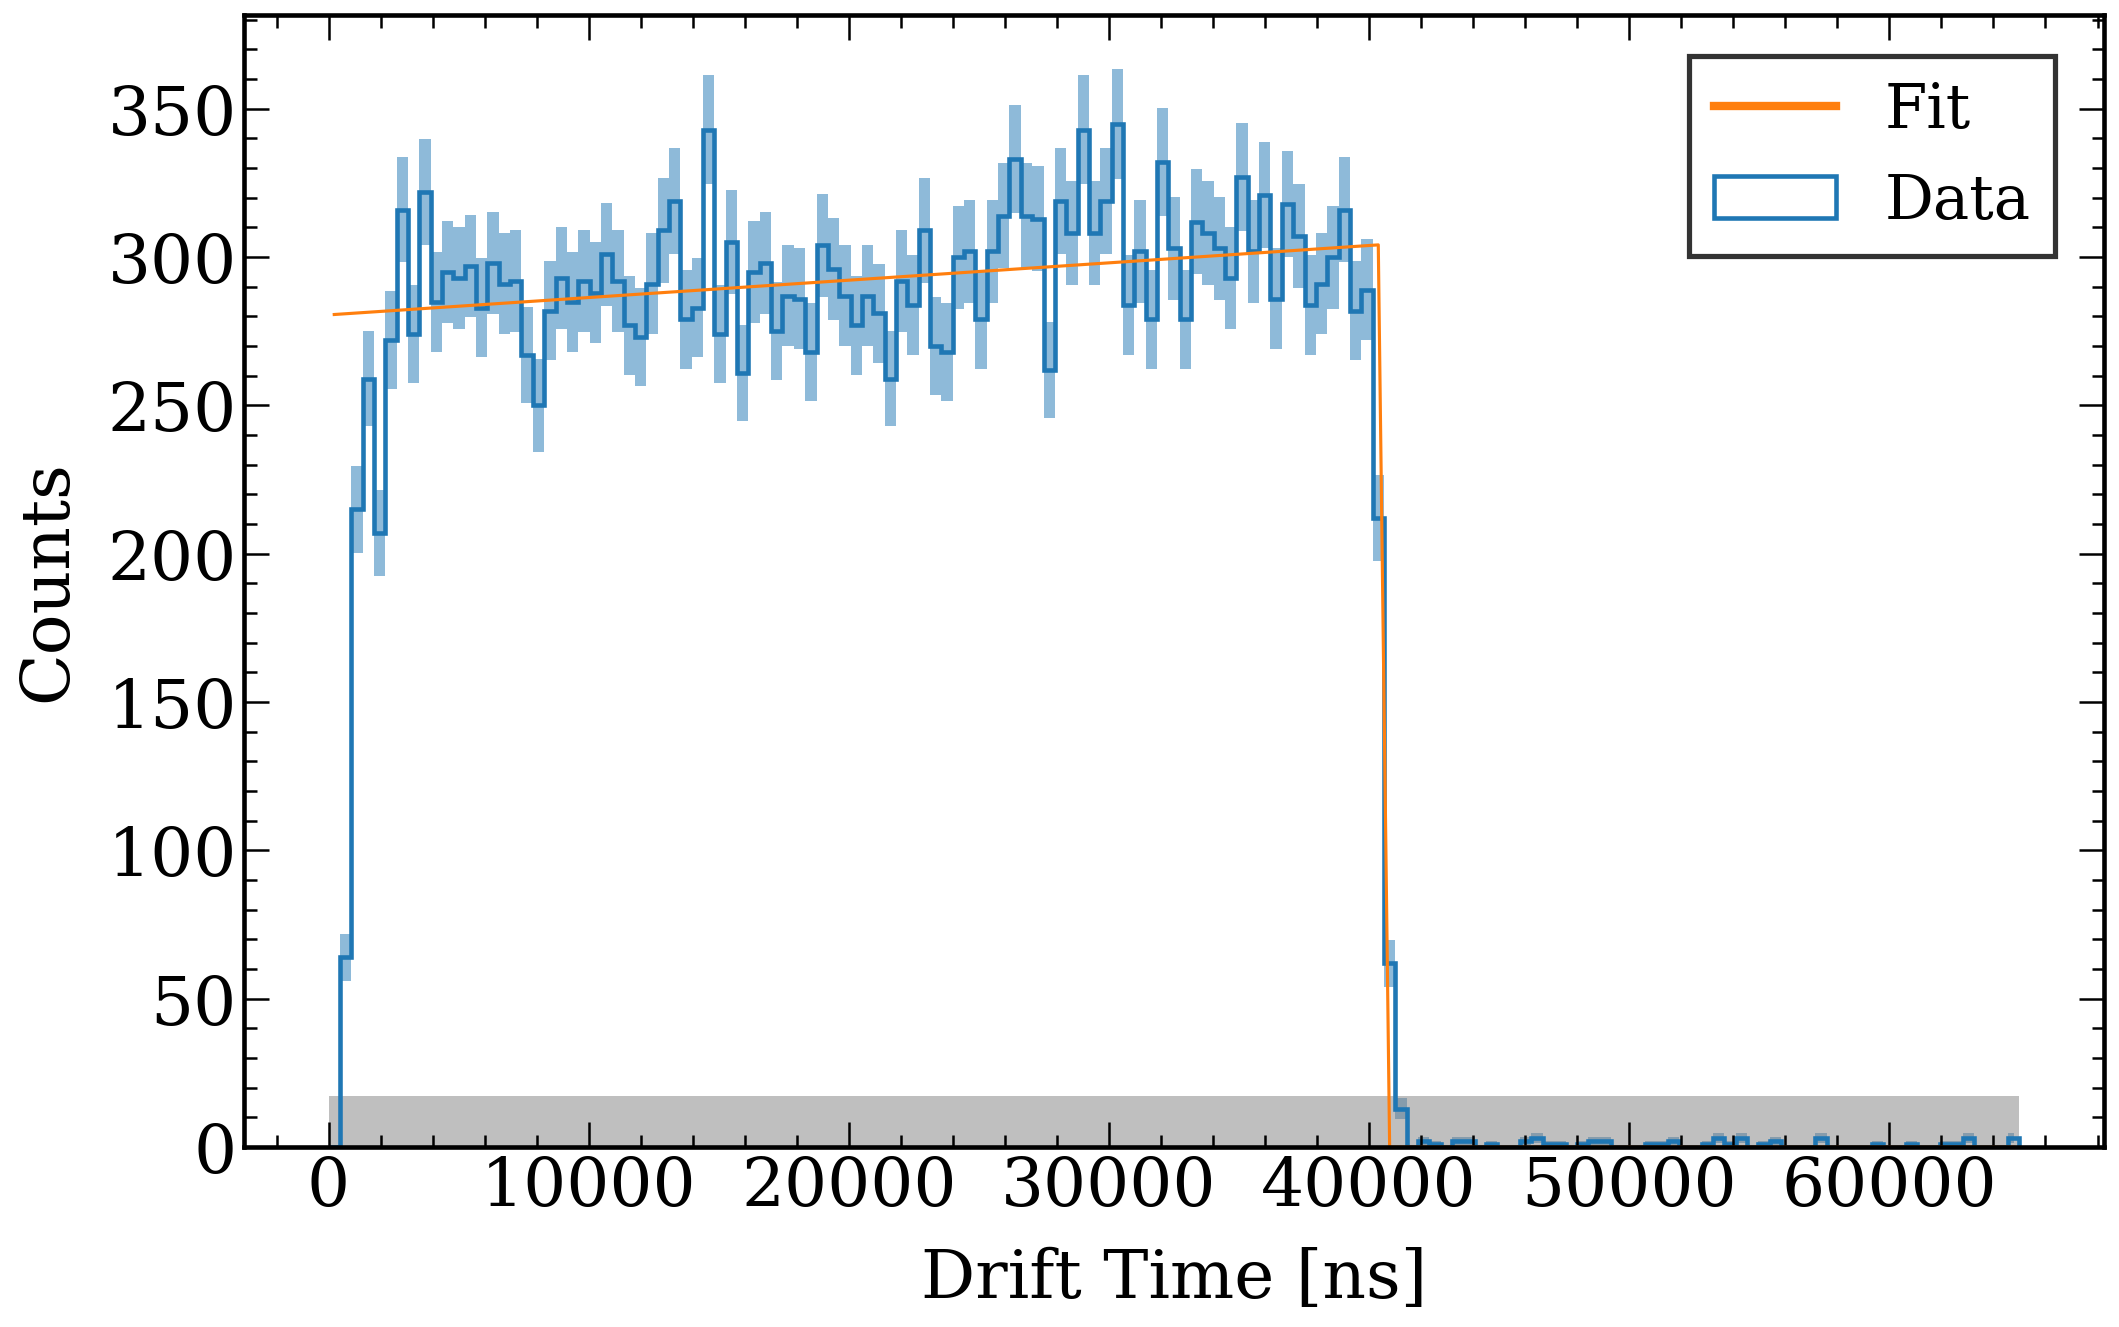

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
time_limit = 65000 # 65000 for E_D = 50 V/cm

bins_x = np.linspace(0,time_limit,150)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

counts,_, patches = plt.hist(Kr_drifttime, bins=bins_x, density = False, 
                            histtype='step', linewidth = 2.2, color = 'C0',
                            label = 'Data')

#plt.scatter(bins_x_center_extended, counts_cut_extended)
plt.plot(bins_x_center, linstep(bins_x_center, *popt), label = 'Fit', color = 'C1')
#plt.plot(bins_x_center, linstep(bins_x_center, *popt), label = 'Fit', color = 'C1')
#plt.plot(bins_x_center_extended, linbox(bins_x_center_extended, 1000, 41000, 280.5, 0.00068), label = 'Fit Guess', color = 'C1')

plt.fill_between(bins_x_center, counts - np.sqrt(counts), counts + np.sqrt(counts), 
                 facecolor='C0', alpha=0.5, step = 'mid')

plt.fill_between(bins_x, 0, cut_min_counts, 
                 facecolor='gray', alpha=0.5, step = 'mid'
                 #, label = 'Excluded\nfrom fit'
                )

plt.xlabel('Drift Time [ns]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

#plt.xlim(0, time_limit)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

plt.show()

In [18]:
# fit linbox
# fails so far

time_limit = 65000 # 65000 for E_D = 50 V/cm
not_cut = np.sum(cut_min_counts_mask)*time_limit/bins
bnds = ((-not_cut*0.1,not_cut*0.7,max(counts)/4,-max(counts)/not_cut),
        (not_cut*0.2, time_limit, 2*max(counts), max(counts)/not_cut))
guess = np.array([1000, 40500, popt_lin[0], popt_lin[1]])
print(bnds)

popt, pcov = curve_fit(linbox, bins_x_center_extended, counts_cut_extended, bounds = bnds, p0 = guess)
print(popt)
print([np.sqrt(pcov[i,i]) for i in range(len(popt))])

((-4030.0, 28210.0, 86.25, -0.008560794044665013), (8060.0, 65000, 690.0, 0.008560794044665013))
[1.00000000e+03 4.05000000e+04 2.80526594e+02 5.79957969e-04]
[0.0, 0.0, 4.233081203329368, 0.00017877003022840664]


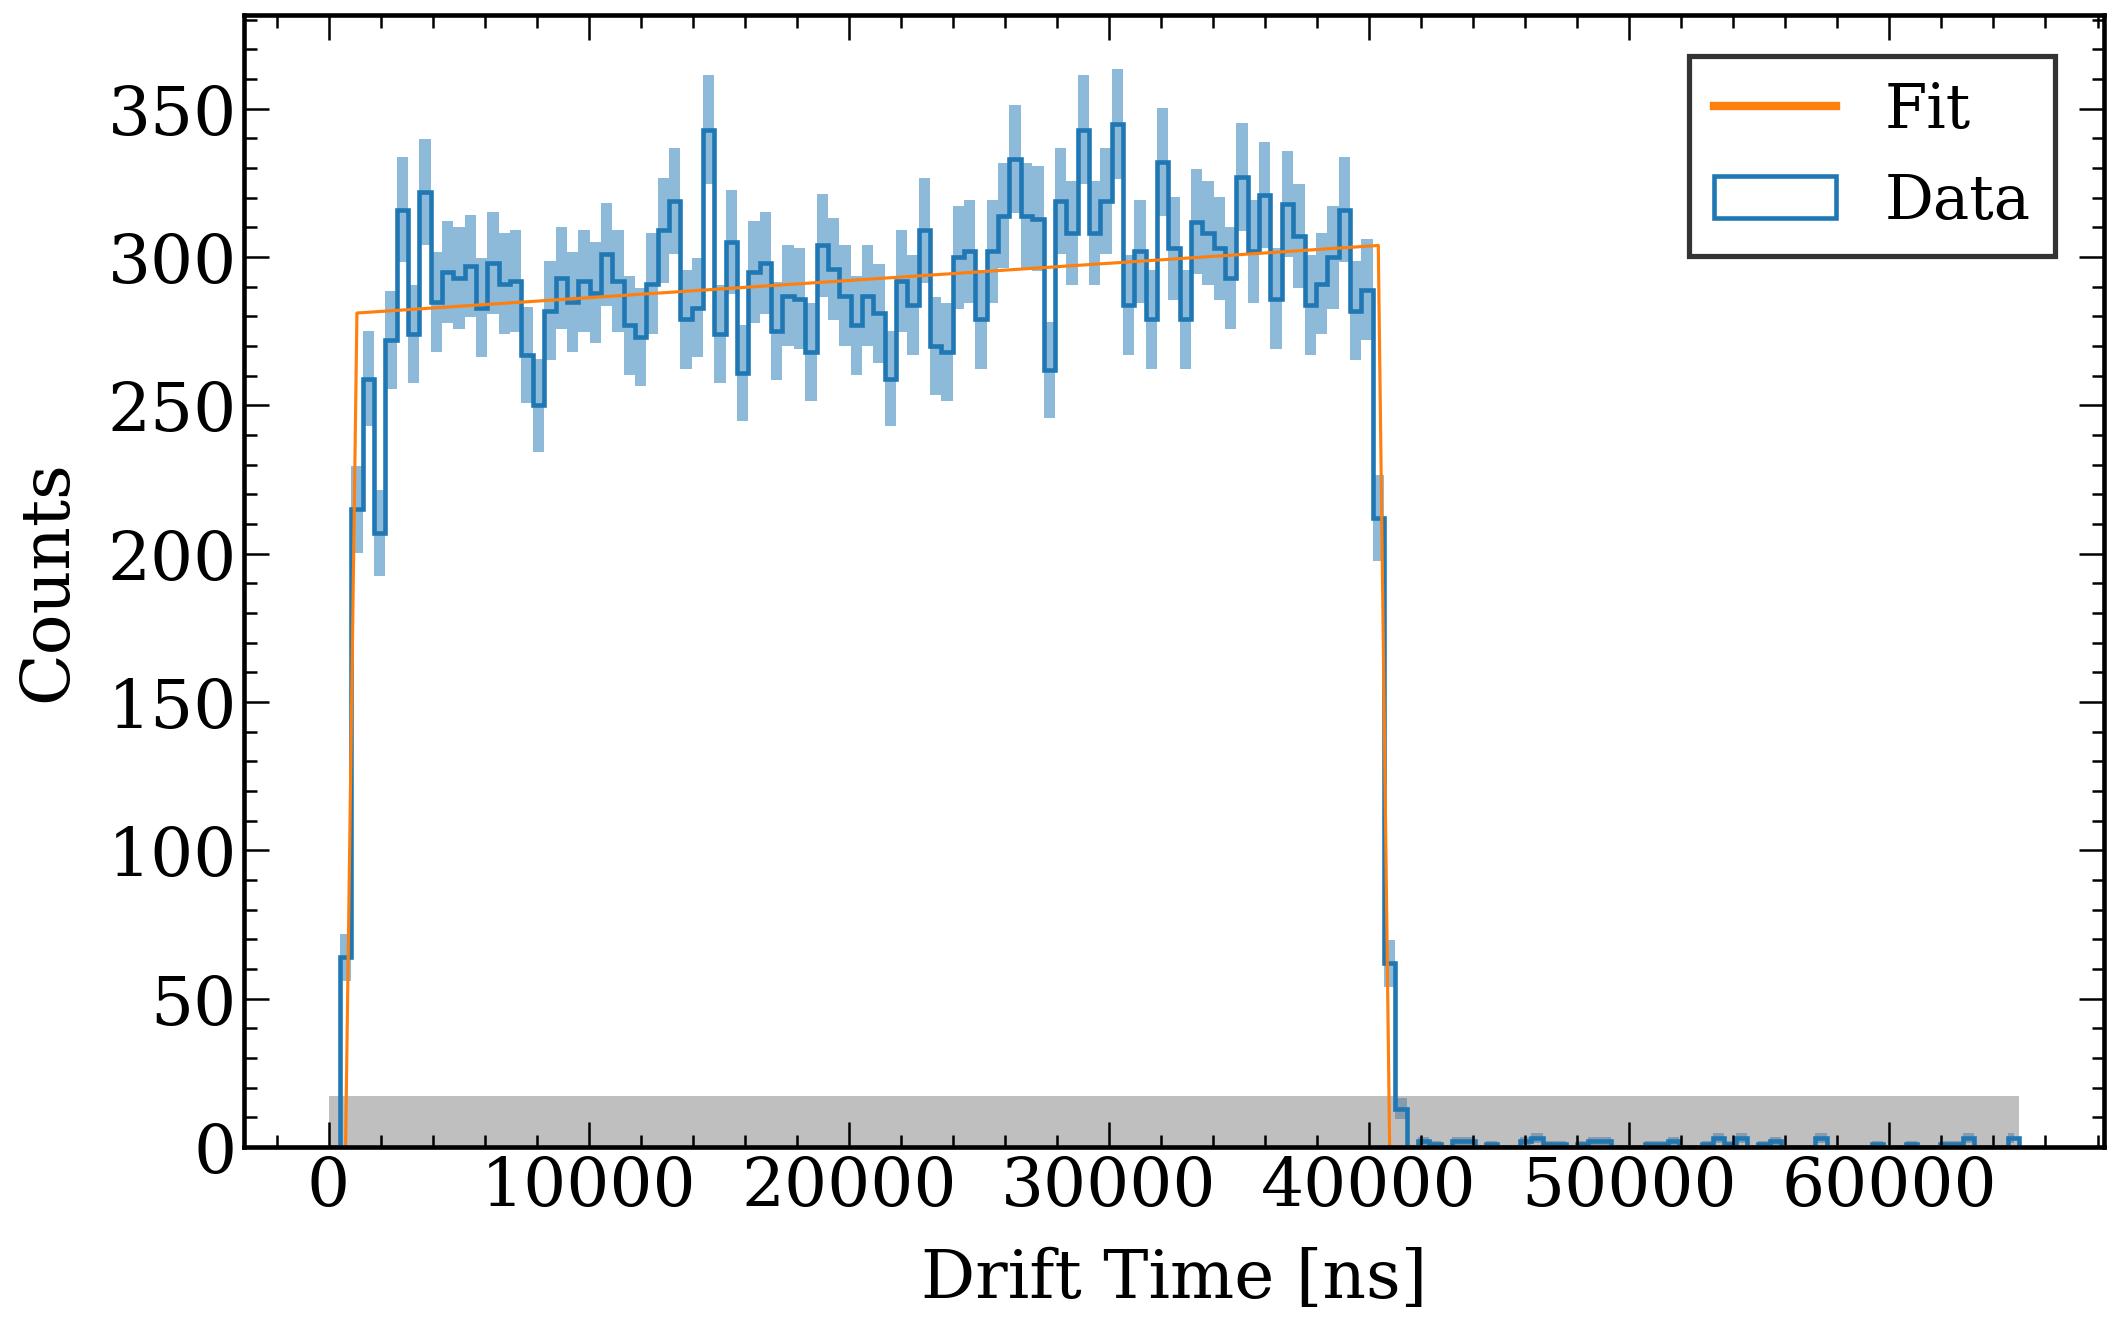

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
time_limit = 65000 # 65000 for E_D = 50 V/cm

bins_x = np.linspace(0,time_limit,150)
bins_x_center = (bins_x[1:] + bins_x[:-1])/2
bin_fullwidths = (bins_x[1:] - bins_x[:-1])

counts,_, patches = plt.hist(Kr_drifttime, bins=bins_x, density = False, 
                            histtype='step', linewidth = 2.2, color = 'C0',
                            label = 'Data')

#plt.scatter(bins_x_center_extended, counts_cut_extended)
plt.plot(bins_x_center, linbox(bins_x_center, *popt), label = 'Fit', color = 'C1')
#plt.plot(bins_x_center, linstep(bins_x_center, *popt), label = 'Fit', color = 'C1')
#plt.plot(bins_x_center_extended, linbox(bins_x_center_extended, 1000, 41000, 280.5, 0.00068), label = 'Fit Guess', color = 'C1')

plt.fill_between(bins_x_center, counts - np.sqrt(counts), counts + np.sqrt(counts), 
                 facecolor='C0', alpha=0.5, step = 'mid')

plt.fill_between(bins_x, 0, cut_min_counts, 
                 facecolor='gray', alpha=0.5, step = 'mid'
                 #, label = 'Excluded\nfrom fit'
                )

plt.xlabel('Drift Time [ns]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

#plt.xlim(0, time_limit)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_drifttime_fit.png")
plt.show()